## Simulation of 11-3.9um brightness temperature difference

**Libraries used:**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd

**Retrieve GFS data:**

In [2]:
%%capture
gfs_file = 'model_data/gfs.t06z.pgrb2.0p25.f000'
gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

**Select region for simulation:**

In [3]:
latitude_north = 43
latitude_south = 36
longitude_west = -70
longitude_east = -60

region = gfs_ds.sel(latitude=slice(latitude_north, latitude_south), longitude=slice(360+longitude_west, 360+longitude_east))

In [4]:
datetime_str = np.datetime_as_string(region.time.values, unit='h')
datetime_str = datetime_str.replace('T', ' ')+"Z"
print(datetime_str)

2023-09-20 06Z


In [5]:
region

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 29, longitude: 41)
Coordinates:
    time           datetime64[ns] 2023-09-20T06:00:00
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 43.0 42.75 42.5 42.25 ... 36.5 36.25 36.0
  * longitude      (longitude) float64 290.0 290.2 290.5 ... 299.5 299.8 300.0
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-05T11:45 GRIB to CDM+CF via cfgrib-0.9.1...

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/2370494745.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


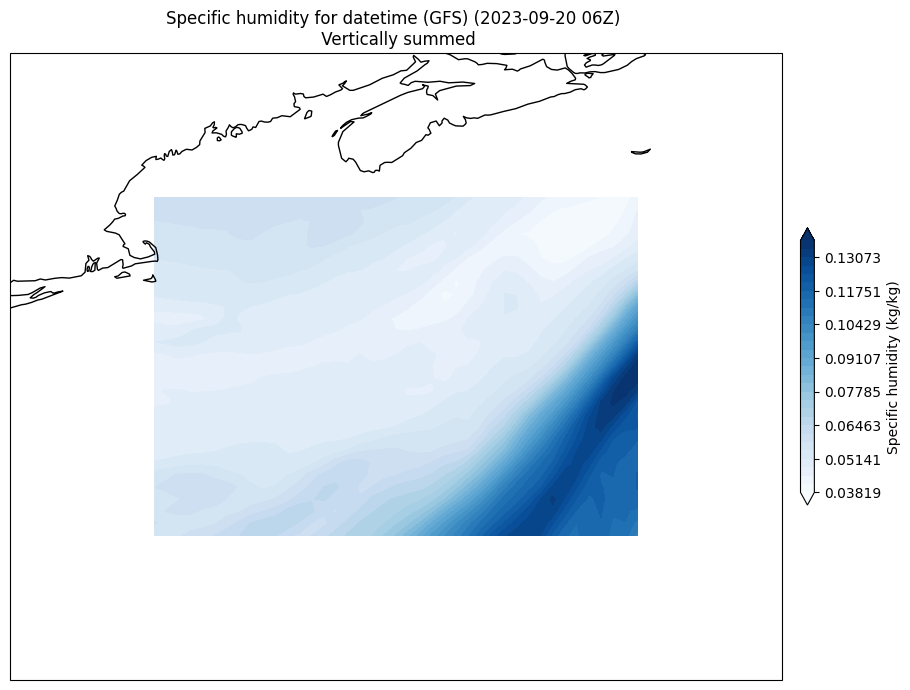

In [6]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Blues
humidity_sum = region.q.sum('isobaricInhPa')
levels = np.linspace(np.min(humidity_sum), np.max(humidity_sum), 31)

c=ax.contourf(region.longitude, region.latitude, humidity_sum, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('Specific humidity (kg/kg)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Specific humidity for datetime (GFS) (" + datetime_str + ") \n Vertically summed" )
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Calculate the water vapor mass density for the region:**
* this is described in RadTran Miller presentation notes
* $r_g$ is the mixing ratio of water vapor, averaged between the layers ($p_1$ and $p_2$)
* mass density ($u$) is in kg m-2

$$
u(p_1, p_2) = \frac{1}{g}\int_{p_2}^{p_1} r_g dp
$$

In [7]:
g = 9.807 #m s-2
u = []

for i in range(len(region.isobaricInhPa.values)-1):
    p1 = region.isobaricInhPa.values[i]*100 #kg s-2 m-1
    p2 = region.isobaricInhPa.values[i+1]*100 #kg s-2 m-1
    dp = p1-p2

    r_g = (region.q.values[i] + region.q.values[i+1]) / 2 #kg kg-1

    u.append((1/g)*r_g*dp) #kg m-2

#--- u has dimensions of (hPa, lat, lon)


**Create an optical mass table:**
* The data is 3-dimensional (pressure, latitude, longitude), so the pandas dataframe is no longer the best method
* Instead, we build an x-array to store the optical mass values

In [8]:
optical_mass_da = xr.DataArray(u, dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})
temperature_da = xr.DataArray(region.t[0:-1], dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})


optical_mass_ds = xr.Dataset({'u': optical_mass_da,
                              'T': temperature_da})

In [9]:
optical_mass_ds

<xarray.Dataset>
Dimensions:  (hPa: 32, lat: 29, lon: 41)
Coordinates:
  * hPa      (hPa) float64 1e+03 975.0 950.0 925.0 900.0 ... 7.0 5.0 3.0 2.0
  * lat      (lat) float64 43.0 42.75 42.5 42.25 42.0 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float64 290.0 290.2 290.5 290.8 ... 299.2 299.5 299.8 300.0
Data variables:
    u        (hPa, lat, lon) float32 2.033 2.046 2.067 ... 2.963e-05 2.968e-05
    T        (hPa, lat, lon) float32 288.9 289.1 289.1 ... 251.8 251.8 252.6

**Open the mass extinction look-up tables:**
* made in water_vapor_abs.ipynb

In [10]:
mass_ext_df_13 = pd.read_pickle('tables/mass_ext_band13')
mass_ext_df_14 = pd.read_pickle('tables/mass_ext_band14')
mass_ext_df_07 = pd.read_pickle('tables/mass_ext_band07')

**Create the optical thickness table (optical mass * mass extinction):**
* using the mass extinction look-up tables (HITRAN-driven)
* using the optical mass table (GFS-driven)

In [11]:
pressure_profile = optical_mass_ds.hPa[:21].values

optical_thickness_07 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])
optical_thickness_13 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])
optical_thickness_14 = np.zeros([len(pressure_profile), len(optical_mass_ds.lat), len(optical_mass_ds.lon)])

print(np.shape(optical_thickness_07))

for z in range(len(pressure_profile)):
    for y in range(len(optical_mass_ds.lat)):
        for x in range(len(optical_mass_ds.lon)):
            
            #--- Getting the T and u from the optical mass dataset
            temperature_value = optical_mass_ds.isel(hPa=z, lat=y, lon=x)['T'].values
            optical_mass_value = optical_mass_ds.isel(hPa=z, lat=y, lon=x)['u'].values

            #---Find the nearest temperature and pressure indices
            nearest_temperature_07 = mass_ext_df_07.index[((mass_ext_df_07.index.values - temperature_value)**2).argmin()]
            nearest_pressure_07 = mass_ext_df_07.columns[((mass_ext_df_07.columns.values - pressure_profile[z])**2).argmin()]

            #---Query the lookup table with the nearest indices
            mass_ext_value_07 = mass_ext_df_07.loc[nearest_temperature_07, nearest_pressure_07]

            optical_thickness_07[z,y,x] = optical_mass_value*mass_ext_value_07

            #---Repeat for the other bands
            nearest_temperature_13 = mass_ext_df_13.index[((mass_ext_df_13.index.values - temperature_value)**2).argmin()]
            nearest_pressure_13 = mass_ext_df_13.columns[((mass_ext_df_13.columns.values - pressure_profile[z])**2).argmin()]
            mass_ext_value_13 = mass_ext_df_13.loc[nearest_temperature_13, nearest_pressure_07]
            optical_thickness_13[z,y,x] = optical_mass_value*mass_ext_value_13

            nearest_temperature_14 = mass_ext_df_14.index[((mass_ext_df_14.index.values - temperature_value)**2).argmin()]
            nearest_pressure_14 = mass_ext_df_14.columns[((mass_ext_df_14.columns.values - pressure_profile[z])**2).argmin()]
            mass_ext_value_14 = mass_ext_df_14.loc[nearest_temperature_14, nearest_pressure_07]
            optical_thickness_14[z,y,x] = optical_mass_value*mass_ext_value_14



(21, 29, 41)


/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/495523805.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


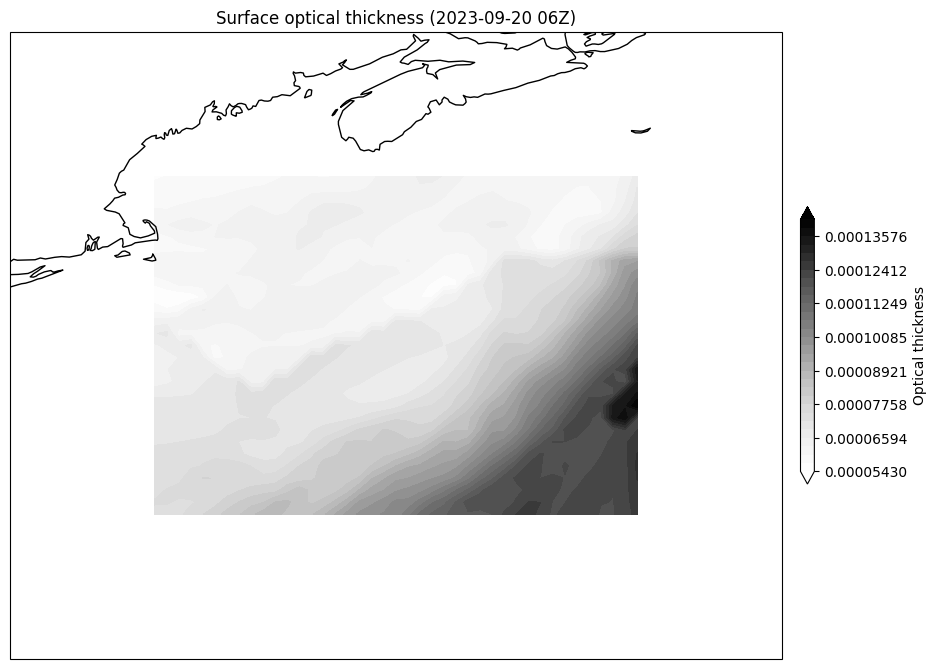

In [12]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Greys
levels = np.linspace(np.min(optical_thickness_07[0,:,:]), np.max(optical_thickness_07[0,:,:]), 31)

c=ax.contourf(region.longitude, region.latitude, optical_thickness_07[0,:,:], cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('Optical thickness')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Surface optical thickness ("+datetime_str+")" )
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Build the functions for expected radiance and brightness temperature:**
* functions are similar to those in expected_radiance.ipynb, but for a 3d field

**Calculating the blackbody radiance ($B_\lambda^\uparrow$):**

$$
B_\lambda (T) = \frac{2hc^2}{\lambda^5 [e^{hc/k\lambda T} -1]}
$$

* $h$ is the Planck constant, $6.626 \times 10^{-34} \text{ J s}$
* $c$ is the speed of light, $3 \times 10^{8} \text{ m s}^{-1}$
* $k$ is the Boltzmann constant, $1.380 \times 10^{-23} \text{ J K}^{-1}$

In [13]:
def blackbody_radiance(T, wl):
    h = 6.626e-34
    c = 3e8
    k = 1.380e-23
    B = (2*h*c**2)/(wl**5 * (np.exp((h*c)/(k*wl*T))-1))
    return B

**Calculating expected radiance ($I_\lambda$):**

$$
I_\lambda^\uparrow (\infty, \mu)= B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu} + \sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

* $B_\lambda^\uparrow (T_\text{sfc})$ is the blackbody radiance from the surface temperature
* $\tau^*$ is optical thickness of atmosphere
* $\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)$ is transmittance upward from height level ($z_i$) to TOA ($\infty$) with viewing angle ($\mu$)

**Calculating radiance from surface:**

Equation for expected radiance ($I_\lambda^\uparrow$) from the surface through the TOA. Includes the total absorption by the optical thickness, but not the individual absorption/emission of each layer. 

$$
B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu}
$$

In [14]:
T_sfc = optical_mass_ds.sel(hPa='1000.0')['T']

def I_sfc(T_sfc, optical_thickness, wl):

    #--- viewing angle of the satellite
    mu = 1

    #--- numpy 3D array sum over the pressure axis
    tau_star = np.sum(optical_thickness, axis=0)
    
    #--- expected radiance calculation
    I_sfc = blackbody_radiance(T_sfc, wl)*np.exp(-tau_star/mu)

    return I_sfc

**Setting wavelength of interest:**

In [15]:
wl = 11.2e-6
optical_thickness = optical_thickness_14
wl_str = "11_2"

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/2063997928.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


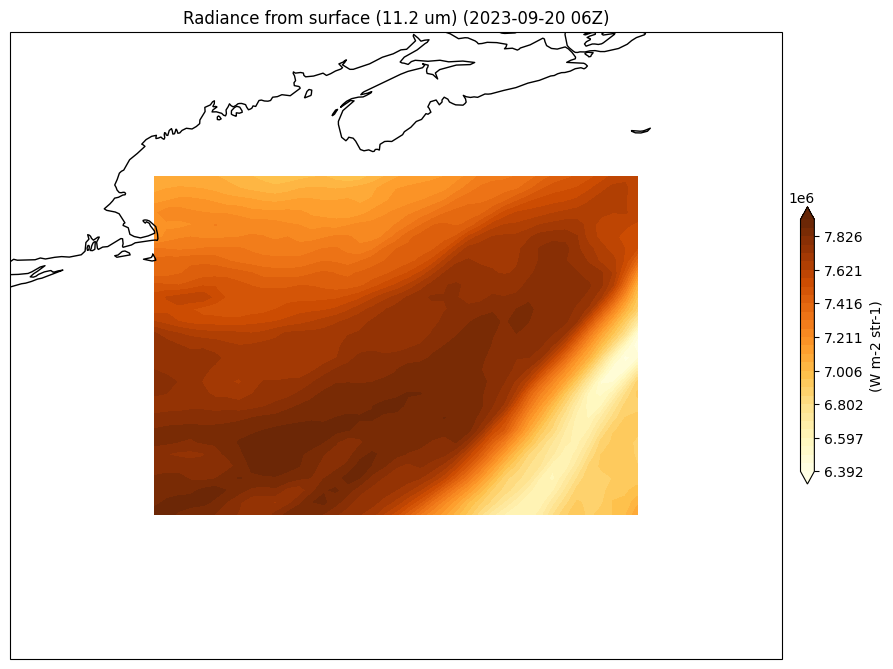

In [16]:
I_sfc_arr = I_sfc(T_sfc, optical_thickness, wl)

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlOrBr
levels = np.linspace(np.min(I_sfc_arr), np.max(I_sfc_arr), 31)

c=ax.contourf(I_sfc_arr.lon, I_sfc_arr.lat, I_sfc_arr, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('(W m-2 str-1)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Radiance from surface ("+ str(wl*1e6) +" um) ("+datetime_str+")")
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Calculating radiance from atmosphere:**

Equation for the expected radiance ($I_\lambda^\uparrow$) from the absorption/emission of each atmospheric layer. 

$$
\sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

In [17]:
def I_atm(optical_thickness, optical_mass_ds, wl):

    #--- Number of pressure levels for integration
    z_len = np.shape(optical_thickness)[0] - 1

    I_levels = []
    mu = 1

    for i in range(z_len):

        #---Temperature and blackbody radiance at current level
        T = optical_mass_ds.isel(hPa=i)['T']
        B = blackbody_radiance(T, wl)

        tau_above = np.sum(optical_thickness[i+1:], axis=0)
        tau_level = np.sum(optical_thickness[i:], axis=0)

        dT = (np.exp(-tau_above/mu)) - (np.exp(-tau_level/mu))
        press_levels = optical_mass_ds['hPa'][:21].values

        #---Change in pressure calculation
        #------Is this swapped? Opposite of what is in expected_radiance.ipynb
        dz = press_levels[i] - press_levels[i+1]
        
        #---Radiance from each atmospheric level
        I_level = B*dT/dz
        I_levels.append(I_level)

    #---Summing the radiance to get the total at TOA
    I_atm = np.sum(I_levels, axis=0)
    return I_atm

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/2248646881.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


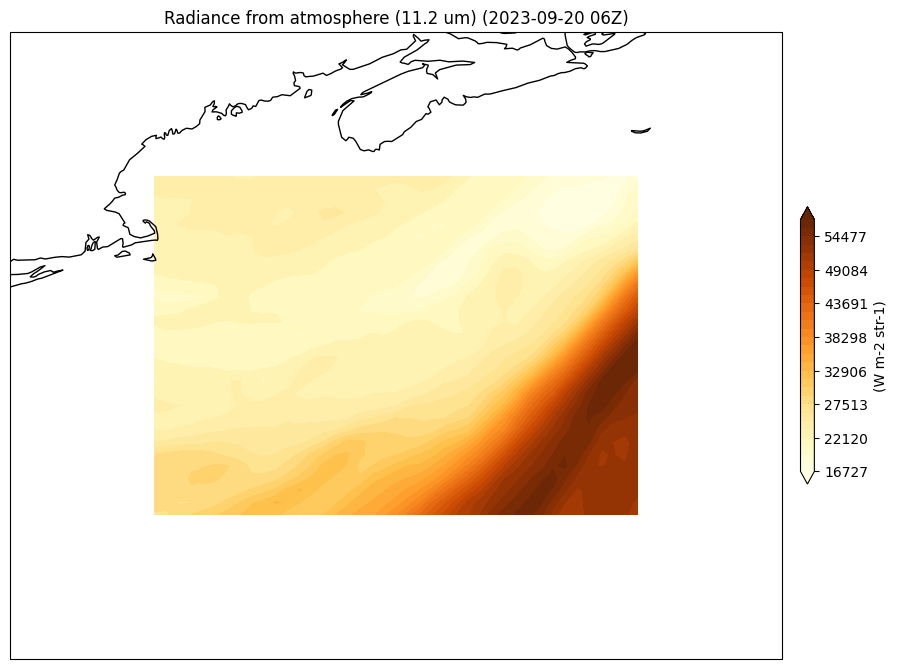

In [18]:
I_atm_arr = I_atm(optical_thickness, optical_mass_ds, wl)

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlOrBr
levels = np.linspace(np.min(I_atm_arr), np.max(I_atm_arr), 31)

c=ax.contourf(I_sfc_arr.lon, I_sfc_arr.lat, I_atm_arr, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('(W m-2 str-1)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Radiance from atmosphere ("+ str(wl*1e6) +" um) ("+datetime_str+")")
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Calculating the total radiance:**

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/406066500.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


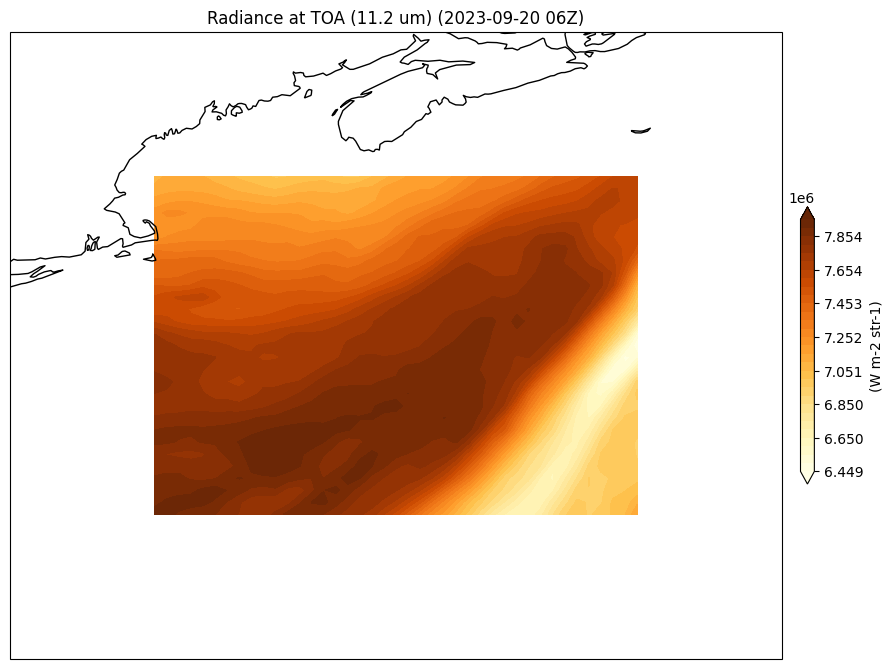

In [19]:
I_tot = I_sfc(T_sfc, optical_thickness, wl) + I_atm(optical_thickness, optical_mass_ds, wl)

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlOrBr
levels = np.linspace(np.min(I_tot), np.max(I_tot), 31)

c=ax.contourf(I_tot.lon, I_tot.lat, I_tot, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('(W m-2 str-1)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Radiance at TOA ("+ str(wl*1e6) +" um) ("+datetime_str+")")
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.show()

**Calculating the brightness temperature:**

Calculating the brightness temperature ($T_{b,\lambda}$) from the expected radiance: 

$$
T_{b,\lambda} = \frac{hc}{k\lambda \text{ ln}\left[1+\frac{2hc^2}{I \lambda^5}\right]}
$$

In [20]:
def brightness_temperature(I, wl):
    h = 6.626e-34
    c = 3e8
    k = 1.380e-23
    Tb = (h*c)/(k*wl * np.log(1 + ((2*h*c**2)/(I*wl**5))))
    return Tb

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/3789157997.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


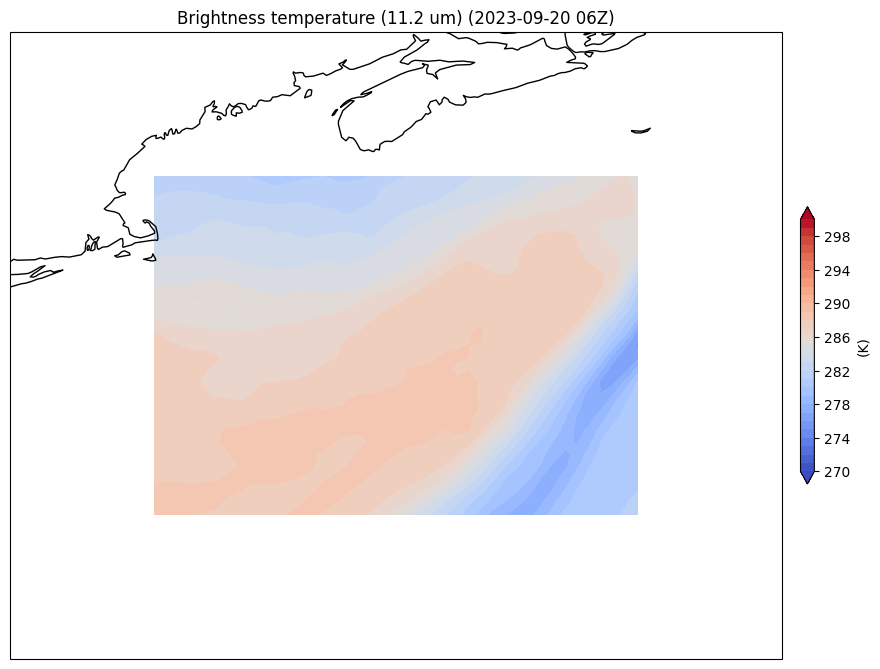

In [21]:
Tb = brightness_temperature(I_tot, wl)

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.coolwarm
levels = np.linspace(270, 300, 31)

c=ax.contourf(Tb.lon, Tb.lat, Tb, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('(K)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Brightness temperature ("+ str(round(wl*1e6, 1)) +" um) ("+datetime_str+")")
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.savefig("/Users/jesseturner/Downloads/brightness_temperature"+wl_str, dpi=200, bbox_inches='tight')
fig.show()

**Calculating the brightness temperature difference:**

In [22]:
first_wl = 11.2e-6
first_optical_thickness = optical_thickness_14
first_wl_str = "11_2"

second_wl = 3.9e-6
second_optical_thickness = optical_thickness_07
second_wl_str = "3_9"

In [23]:
first_I_tot = I_sfc(T_sfc, first_optical_thickness, first_wl) + I_atm(first_optical_thickness, optical_mass_ds, first_wl)
second_I_tot = I_sfc(T_sfc, second_optical_thickness, second_wl) + I_atm(second_optical_thickness, optical_mass_ds, second_wl)

BTD = brightness_temperature(first_I_tot, first_wl) - brightness_temperature(second_I_tot, second_wl)

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_49969/1096702272.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


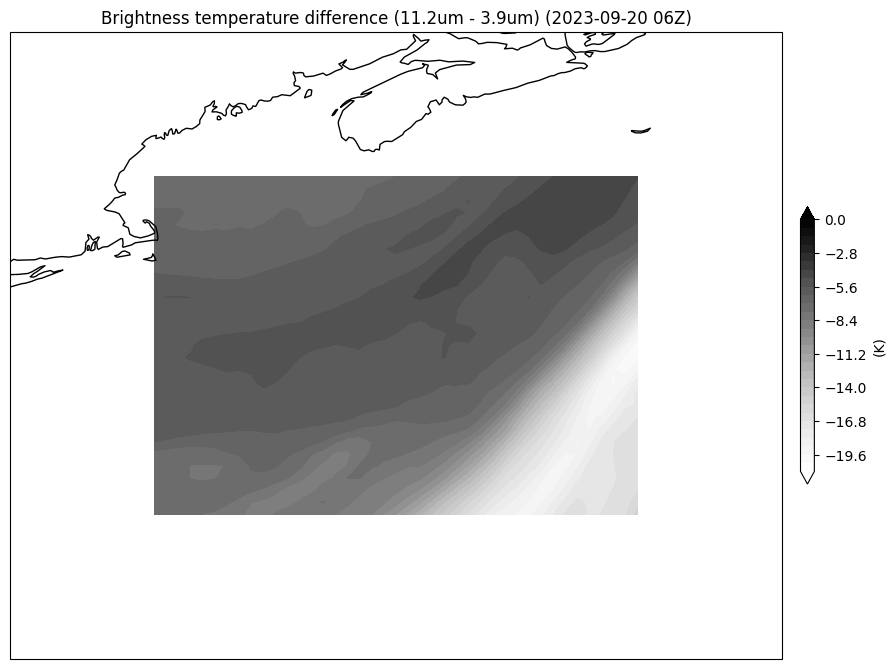

In [24]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Greys
levels = np.linspace(-21, 0, 31)

c=ax.contourf(BTD.lon, BTD.lat, BTD, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
clb.set_label('(K)')

ax.set_extent([longitude_west-3, longitude_east+3, latitude_south-3, latitude_north+3], crs=ccrs.PlateCarree())

ax.set_title("Brightness temperature difference ("+ str(round(first_wl*1e6, 1)) + "um - " + str(round(second_wl*1e6, 1)) +"um) ("+datetime_str+")")
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.savefig("/Users/jesseturner/Downloads/BTD_"+first_wl_str+"_minus_"+second_wl_str, dpi=200, bbox_inches='tight')
fig.show()